# 1. 思路过程

## 1、问题理解
根据Y为是否购买，判断为二分类问题。或者考虑聚类。
考虑聚类，K-means, lid, knn

## 2、模型选择
选用二分类模型：xgb、随机森林。。。，多模型融合TOP1/评估权重进行组合
二分类模型评估指标：混淆矩阵/AUC?

## 3、特征工程
1. 数据探索：分布、缺失、异常
2. 特征清洗、转换
3. 特征衍生：log/归一化，one-hot，缺失特征one-hot，加减乘除，因子分析，奇异值分解，其他模型特征；时序特征处理；
4. 特征筛选：因变量相关分析，自变量相关特征筛选，随机森林/XGB 特征权重选择 -- 有用信息涵盖，针对高价值特征 深度挖掘及分析

## 4、模型训练
数据集划分，交叉检验？
模型融合输出？

# 1. 环境准备

In [8]:
HOME_DIRECTORY="/home/shawn/workspace/research/ant/"

In [349]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import seaborn as sns
import os
import pickle
import math
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model.logistic import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
from tqdm import tqdm
import csv
import time
import sys

# 1. Data Explantory: 

首先看数据的分布, 缺失, 异常, 相关性

In [543]:
ads_train = pd.read_csv(os.path.join(HOME_DIRECTORY,'data/ads_train.csv'), sep=',')
ads_test = pd.read_csv(os.path.join(HOME_DIRECTORY,'data/ads_test.csv'), sep=',')
ads_train = ads_train.drop('Unnamed: 0',axis=1)
ads_test = ads_test.drop('Unnamed: 0',axis=1)

In [351]:
print(ads_train.shape)
print(ads_test.shape)

(38209, 14)
(16375, 13)


In [352]:
"""
1620/38290 = 4%的有数据，大多数buy_freq是空值。
1. 使用有值的mean value作为其他的一个estimator。
2. 不使用该列
使用该列。
"""
print(ads_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38209 entries, 0 to 38208
Data columns (total 14 columns):
isbuyer                38209 non-null int64
buy_freq               1620 non-null float64
visit_freq             38209 non-null int64
buy_interval           38209 non-null float64
sv_interval            38209 non-null float64
expected_time_buy      38209 non-null float64
expected_time_visit    38209 non-null float64
last_buy               38209 non-null int64
last_visit             38209 non-null int64
multiple_buy           38209 non-null int64
multiple_visit         38209 non-null int64
uniq_urls              38209 non-null int64
num_checkins           38209 non-null int64
y_buy                  38209 non-null int64
dtypes: float64(5), int64(9)
memory usage: 4.1 MB
None


In [353]:
ads_train.head()

,isbuyer,buy_freq,visit_freq,buy_interval,sv_interval,expected_time_buy,expected_time_visit,last_buy,last_visit,multiple_buy,multiple_visit,uniq_urls,num_checkins,y_buy
0,0,NaN,1,0.0,0.00000,0.0,0.00000,106,106,0,0,169,2130,0
1,0,NaN,1,0.0,0.00000,0.0,0.00000,6,6,0,0,150,539,0
2,0,NaN,2,0.0,0.50000,0.0,-101.14930,101,101,0,1,103,362,0
3,0,NaN,1,0.0,0.00000,0.0,0.00000,42,42,0,0,17,35,0
4,0,NaN,3,0.0,45.47917,0.0,-34.14473,64,64,0,1,100,298,0


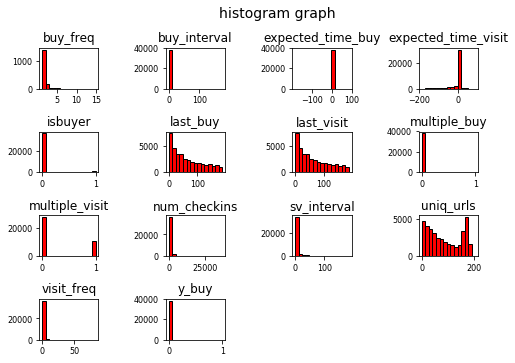

In [355]:
# 数据分布情况
"""
很多特征都没有数据，我们想看看这些没有数据的，是否能够体现出buyers来。可以考虑画这些图的outlier(boxplot等)，看是否和buyers相关。
"""
ads_train.hist(bins=15, color='red', edgecolor='black', linewidth=1.0,
              xlabelsize=8, ylabelsize=8, grid=False)    
plt.tight_layout(rect=(0, 0, 1.2, 1.2))   
rt = plt.suptitle('histogram graph', x=0.65, y=1.25, fontsize=14)  

In [366]:
# 从百分位数中可以看出来，特征中的数据，除了last_buy, last_vist, uniq_urls, num_checkins外，其他的分布极其不平衡
# num_checkins有数据很大，可以看下
ads_train.describe()

,isbuyer,buy_freq,visit_freq,buy_interval,sv_interval,expected_time_buy,expected_time_visit,last_buy,last_visit,multiple_buy,multiple_visit,uniq_urls,num_checkins,y_buy
count,38209.000000,1620.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000
mean,0.042398,1.239506,1.868199,0.197411,5.862179,-0.174376,-10.136685,64.657384,64.657384,0.005967,0.277526,86.594624,723.834515,0.004502
std,0.201499,0.840259,2.996675,3.855662,17.726455,4.784059,31.796845,53.453475,53.453475,0.077018,0.447784,61.941089,1286.380572,0.066943
min,0.000000,1.000000,0.000000,0.000000,0.000000,-181.923800,-187.615600,0.000000,0.000000,0.000000,0.000000,-1.000000,1.000000,0.000000
25%,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,18.000000,18.000000,0.000000,0.000000,30.000000,127.000000,0.000000
50%,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,50.000000,50.000000,0.000000,0.000000,75.000000,319.000000,0.000000
75%,0.000000,1.000000,2.000000,0.000000,0.125000,0.000000,0.000000,105.000000,105.000000,0.000000,1.000000,155.000000,803.000000,0.000000
max,1.000000,15.000000,84.000000,174.625000,184.916700,84.285710,91.401920,188.000000,188.000000,1.000000,1.000000,206.000000,37091.000000,1.000000


In [479]:
X = ads_train.drop('y_buy',axis=1)
y = ads_train['y_buy']
from collections import Counter
# 查看所生成的样本类别分布，0和1样本比例222比1，属于类别极不平衡数据
print(Counter(y))

Counter({0: 38037, 1: 172})


/home/shawn/anaconda3/envs/python36/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.
/home/shawn/anaconda3/envs/python36/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


Counter({0: 5139, 1: 104})

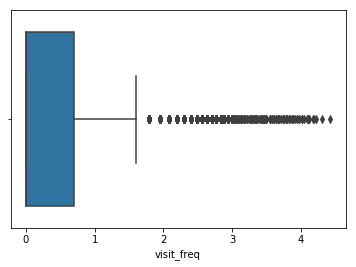

In [380]:
sns.boxplot(x=np.log(X['visit_freq']))
Counter(ads_train[np.log(ads_train['visit_freq'])>1]['y_buy'])

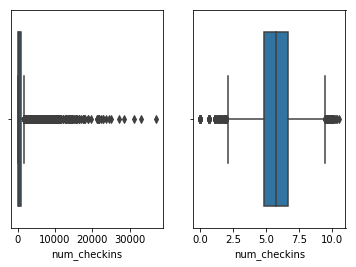

In [376]:
# 我们对num_checkins做log，可以看到outliers
fig, axs = plt.subplots(ncols=2)
sns.boxplot(x=X['num_checkins'], ax=axs[0])
sns.boxplot(x=np.log(X['num_checkins']), ax=axs[1])

In [371]:
"""
((172, 13), (38037, 13)) 正负样本极其不均衡，购买者的数据很少, 仅0.45%。
"""
is_buyer.shape, not_buyer.shape

((172, 13), (38037, 13))

In [377]:
is_buyer = ads_train[ads_train['y_buy']==1]
not_buyer = ads_train[ads_train['y_buy']==0]
is_buyer_desc = round(is_buyer.describe(), 4)
not_buyer_desc = round(not_buyer.describe(), 4)
pd.concat([is_buyer_desc, is_buyer_desc], axis=1, keys=['is_buyer_desc', 'not_buyer_desc'])

is_buyer_desc                                               \
            isbuyer buy_freq visit_freq buy_interval sv_interval   
count      172.0000  63.0000   172.0000     172.0000    172.0000   
mean         0.3663   1.8254     7.3663       4.7012      7.9720   
std          0.4832   1.9719    10.3951      17.2162     11.6503   
min          0.0000   1.0000     0.0000       0.0000      0.0000   
25%          0.0000   1.0000     1.0000       0.0000      0.0000   
50%          0.0000   1.0000     4.0000       0.0000      3.5396   
75%          1.0000   2.0000     9.0000       0.0000     11.9102   
max          1.0000  15.0000    65.0000     155.0833     85.7708   

                                                                               \
      expected_time_buy expected_time_visit  last_buy last_visit multiple_buy   
count          172.0000            172.0000  172.0000   172.0000     172.0000   
mean            -3.5378             -5.2691   20.2674    20.2674       0.1453   
std             17.5976             25.7413   36.4279    36.4279       0.3535   
min           -115.2760           -182.2078    0.0000     0.0000       0.0000   
25%              0.0000             -1.3905    0.0000     0.0000       0.0000   
50%              0.0000              0.0000    4.0000     4.0000       0.0000   
75%              0.0000              3.2798   21.2500    21.2500       0.0000   
max             52.5074             57.1615  182.0000   182.0000       1.0000   

       ...   not_buyer_desc                                                  \
       ...      sv_interval expected_time_buy expected_time_visit  last_buy   
count  ...         172.0000          172.0000            172.0000  172.0000   
mean   ...           7.9720           -3.5378             -5.2691   20.2674   
std    ...          11.6503           17.5976             25.7413   36.4279   
min    ...           0.0000         -115.2760           -182.2078    0.0000   
25%    ...           0.0000            0.0000             -1.3905    0.0000   
50%    ...           3.5396            0.0000              0.0000    4.0000   
75%    ...          11.9102            0.0000              3.2798   21.2500   
max    ...          85.7708           52.5074             57.1615  182.0000   

                                                                            
      last_visit multiple_buy multiple_visit uniq_urls num_checkins  y_buy  
count   172.0000     172.0000       172.0000  172.0000     172.0000  172.0  
mean     20.2674       0.1453         0.7151   66.5058     545.3547    1.0  
std      36.4279       0.3535         0.4527   60.6795     912.3537    0.0  
min       0.0000       0.0000         0.0000   -1.0000       9.0000    1.0  
25%       0.0000       0.0000         0.0000   15.0000      82.0000    1.0  
50%       4.0000       0.0000         1.0000   42.0000     240.5000    1.0  
75%      21.2500       0.0000         1.0000  115.0000     565.7500    1.0  
max     182.0000       1.0000         1.0000  189.0000    6516.0000    1.0  

[8 rows x 28 columns]

In [93]:
"""
我们可以简单的基于mean, percentile,和std预测下，也可以使用统计显著性:
1. isbuyer=1的即过去是buyer的，更会购买
2. visit_freq大的，更会购买
4. sv_interval大的，更会购买。
5. last_buy小的，更会购买。
6. last_visit小的，更会购买。 (last_buy和last_visit，相关性很高)
7. multiple_buy大的，更会购买。
8. multiple_visit，更会购买。
uniq_urls	num_checkins
"""
is_buyer_desc

,isbuyer,visit_freq,buy_interval,sv_interval,expected_time_buy,expected_time_visit,last_buy,last_visit,multiple_buy,multiple_visit,uniq_urls,num_checkins,y_buy
count,172.0000,172.0000,172.0000,172.0000,172.0000,172.0000,172.0000,172.0000,172.0000,172.0000,172.0000,172.0000,172.0
mean,0.3663,7.3663,4.7012,7.9720,-3.5378,-5.2691,20.2674,20.2674,0.1453,0.7151,66.5058,545.3547,1.0
std,0.4832,10.3951,17.2162,11.6503,17.5976,25.7413,36.4279,36.4279,0.3535,0.4527,60.6795,912.3537,0.0
min,0.0000,0.0000,0.0000,0.0000,-115.2760,-182.2078,0.0000,0.0000,0.0000,0.0000,-1.0000,9.0000,1.0
25%,0.0000,1.0000,0.0000,0.0000,0.0000,-1.3905,0.0000,0.0000,0.0000,0.0000,15.0000,82.0000,1.0
50%,0.0000,4.0000,0.0000,3.5396,0.0000,0.0000,4.0000,4.0000,0.0000,1.0000,42.0000,240.5000,1.0
75%,1.0000,9.0000,0.0000,11.9102,0.0000,3.2798,21.2500,21.2500,0.0000,1.0000,115.0000,565.7500,1.0
max,1.0000,65.0000,155.0833,85.7708,52.5074,57.1615,182.0000,182.0000,1.0000,1.0000,189.0000,6516.0000,1.0


In [94]:
not_buyer_desc

,isbuyer,visit_freq,buy_interval,sv_interval,expected_time_buy,expected_time_visit,last_buy,last_visit,multiple_buy,multiple_visit,uniq_urls,num_checkins,y_buy
count,38037.0000,38037.0000,38037.0000,38037.0000,38037.0000,38037.0000,38037.0000,38037.0000,38037.0000,38037.0000,38037.0000,38037.0000,38037.0
mean,0.0409,1.8433,0.1770,5.8526,-0.1592,-10.1587,64.8581,64.8581,0.0053,0.2755,86.6855,724.6416,0.0
std,0.1981,2.8979,3.6754,17.7487,4.6419,31.8202,53.4348,53.4348,0.0729,0.4468,61.9327,1287.7775,0.0
min,0.0000,0.0000,0.0000,0.0000,-181.9238,-187.6156,0.0000,0.0000,0.0000,0.0000,-1.0000,1.0000,0.0
25%,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,18.0000,18.0000,0.0000,0.0000,30.0000,127.0000,0.0
50%,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,51.0000,51.0000,0.0000,0.0000,75.0000,319.0000,0.0
75%,0.0000,2.0000,0.0000,0.0833,0.0000,0.0000,105.0000,105.0000,0.0000,1.0000,155.0000,804.0000,0.0
max,1.0000,84.0000,174.6250,184.9167,84.2857,91.4019,188.0000,188.0000,1.0000,1.0000,206.0000,37091.0000,0.0


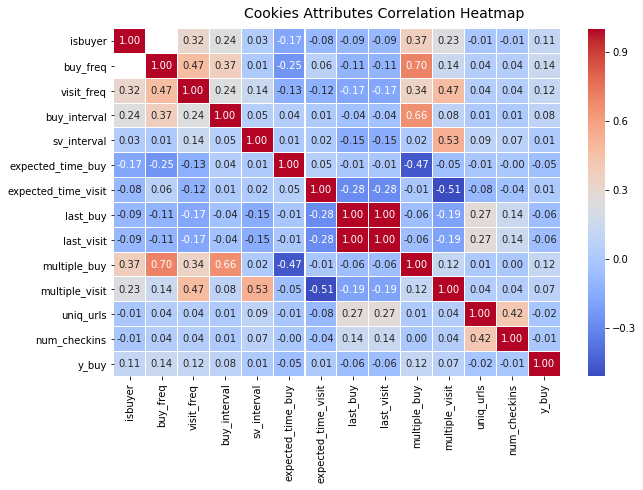

In [410]:
"""
看线性相关系数，没有高度相关的。
0 < x < 0.3 低度相关
0.3 < x < 0.8 中度相关
"""
f, ax = plt.subplots(figsize=(10, 6))
corr = ads_train.corr()
hm = sns.heatmap(round(corr,2), annot=True, ax=ax, cmap="coolwarm",fmt='.2f',
            linewidths=.05)
f.subplots_adjust(top=0.93)
t= f.suptitle('Cookies Attributes Correlation Heatmap', fontsize=14)

In [ ]:
def plot_tsne(X, y):
    """
    t-sne数据可视化
    """
    from sklearn.manifold import TSNE
    from matplotlib import pyplot as plt
    tsne = TSNE(n_components=2, random_state=0)
    X_2d = tsne.fit_transform(X)
    target_ids = range(2)
    plt.figure(figsize=(6, 5))
    for i in range(2):
        plt.scatter(X_2d[y == i, 0], X_2d[y == i, 1], label=i)
    plt.legend()
    plt.show()
# 数据极其不平衡
"""
考虑可以使用
1. oversampling
2. undersampling
3. smote
"""
plot_tsne(X, y)

# cleaning



特征清洗、转换 特征衍生

## 1. 数据的清洗和转换

In [523]:
X = ads_train.drop('y_buy',axis=1)
y = ads_train['y_buy']
from collections import Counter
# 查看所生成的样本类别分布，0和1样本比例222比1，属于类别极不平衡数据
print(Counter(y))

# fill nan value，使用mean_value作为estimator
mean_value = np.mean(X['buy_freq'])
X['buy_freq'].fillna(mean_value, inplace=True)

# remove outliers, 这么高的check_in不合理。
print(Counter(ads_train[np.log(ads_train['num_checkins'])>9]['y_buy']))
drop_index = X[np.log(X['num_checkins'])>9].index
X = X.drop(drop_index)
y = y.drop(drop_index)
assert X[np.log(X['num_checkins'])>9].shape[0] == 0
assert X.shape[0] == y.shape[0]

Counter({0: 38037, 1: 172})
Counter({0: 154})


### 2. 特征衍生: 多项式特征

In [521]:
# # 标准化：如果数据存在异常值和较多噪音，通过标准化，可以间接通过中心化避免异常值和极端值的影响
# from sklearn.preprocessing import StandardScaler
# X = StandardScaler().fit_transform(X)
# X.shape

/home/shawn/anaconda3/envs/python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/shawn/anaconda3/envs/python36/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


(38055, 13)

In [462]:
# from sklearn.preprocessing import PolynomialFeatures
# X = PolynomialFeatures().fit_transform(X)
# X.shape

(38055, 105)

## 3. feature selection

In [524]:
## 3. feature selection
### 1. 基于variance
from sklearn.feature_selection import VarianceThreshold
selector = VarianceThreshold(threshold=3)
selector.fit_transform(X)
X = X[X.columns[selector.get_support(indices=True)]]
X.shape

(38055, 9)

In [526]:
column_names = X.columns
column_names

Index(['visit_freq', 'buy_interval', 'sv_interval', 'expected_time_buy',
       'expected_time_visit', 'last_buy', 'last_visit', 'uniq_urls',
       'num_checkins'],
      dtype='object')

In [468]:
def nowtime():
    import datetime
    return datetime.datetime.now()

# confusion matrix
def plot_confusion_matrox(y_actual, y_pred):
    from sklearn.metrics import confusion_matrix
    confusion_matrix = confusion_matrix(y_actual, y_pred)
    print(confusion_matrix)
    plt.matshow(confusion_matrix)
    plt.title('Confusion matrix')
    plt.colorbar()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

## 4. 数据不均衡，需要进行re-sampling。否则效果非常差。

In [ ]:
# training model
# 我们使用oversampling中的一种: smote。
# 主要利用positive sample去生成假的positive sample
rs = 123
smo = SMOTE(random_state=rs)
X_train, X_test, y_train, y_test = train_test_split(X,y)
X_smo, y_smo = smo.fit_sample(X_train, y_train)
X_train, y_train = X_smo, y_smo

假设营销成本很低的情况下：我们希望找出尽量多的买家，根据这样一个业务场景，我们需要我们的recall越高越好。所以我使用recall作为metric.


## Baseline: LR 

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   12.1s finished
/home/shawn/anaconda3/envs/python36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Training spending: 0:00:12.312520
----------------------------------------------------------------
Best score: 0.821
Best parameters set:
	lr__C: 1
	lr__penalty: 'l1'
----------------------------------------------------------------
Accuracy: 0.7759091864620559
Precision: 0.012552301255230125
Recall: 0.7714285714285715
----------------------------------------------------------------
[[7355 2124]
 [   8   27]]


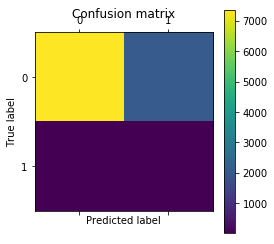

----------------------------------------------------------------


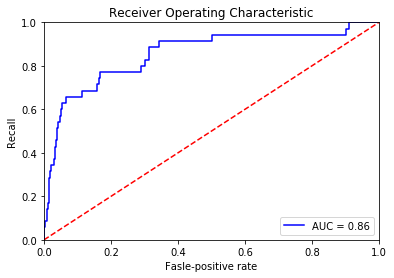

In [503]:
# Logistic Regression BaseLine
begin_time = nowtime()

# Gridsearch settings
pipeline = Pipeline([
       ('lr', LogisticRegression())
   ])
parameters = {
       'lr__penalty': ('l1', 'l2'),
       'lr__C': (0.01, 0.1, 1, 5, 10),
 }
grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1, scoring='recall', cv=10)
grid_search.fit(X_train, y_train)
end_time = nowtime()
print("Training spending: {}".format(str(end_time-begin_time)))
print('----------------------------------------------------------------')
print('Best score: %0.3f' % grid_search.best_score_)
print('Best parameters set:')
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print('\t%s: %r' % (param_name, best_parameters[param_name]))
predictions = grid_search.predict(X_test)
len(predictions)
print('----------------------------------------------------------------')
print('Accuracy:', accuracy_score(y_test, predictions))
# 查准率，TP/预测中的所有positive的个数。
print('Precision:', precision_score(y_test, predictions))
# 查全率，TP/实际上为positive的个数
print('Recall:', recall_score(y_test, predictions))
print('----------------------------------------------------------------')
plot_confusion_matrix(y_test, predictions)
print('----------------------------------------------------------------')
best_estimator_lr = grid_search.best_estimator_.steps[0][1]
predictions_prob = best_estimator_lr.predict_proba(X_test)
false_positive_rate, recall, thresholds = roc_curve(y_test, predictions_prob[:, 1])
roc_auc = auc(false_positive_rate, recall)
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, recall, 'b', label='AUC = %0.2f' %roc_auc)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.ylabel('Recall')
plt.xlabel('Fasle-positive rate')
plt.show()

我们生成的正负样本数据training set对比test set，刻画了一定真实的分布。

In [566]:
lr_label_array = best_estimator_lr.predict(ads_test)
print(lr_label_array)
with open('lr_label_array' + '.pickle', 'wb') as fp:
        pickle.dump(lr_label_array, fp)

[0 1 0 ... 1 0 0]


In [565]:
lr_prob_array = best_estimator_lr.predict_proba(ads_test)
print(lr_prob_array)
with open('lr_prob_array' + '.pickle', 'wb') as fp:
        pickle.dump(lr_prob_array, fp)

[[0.87745088 0.12254912]
 [0.3828317  0.6171683 ]
 [0.62615819 0.37384181]
 ...
 [0.09497039 0.90502961]
 [0.92841379 0.07158621]
 [0.81107639 0.18892361]]


## Random Forest

In [ ]:
我们考虑用ensmber模型

## Random Forest

Training spending: 0:01:41.298802
----------------------------------------------------------------
Best model:
----------------------------------------------------------------
Best score: 0.987
Best parameters set:
	max_depth: 15
	max_features: 'auto'
	n_estimators: 100
----------------------------------------------------------------
Scores:
----------------------------------------------------------------
Recall score: 0.987
Accuracy: 0.9725667437460584
Precision: 0.12413793103448276
Recall: 0.8372093023255814
----------------------------------------------------------------
Confusion Matrix:
----------------------------------------------------------------
[[9217  254]
 [   7   36]]


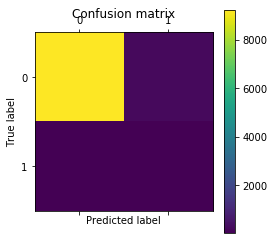

----------------------------------------------------------------
                            0
visit_freq           0.220244
sv_interval          0.211999
last_visit           0.127192
num_checkins         0.112426
last_buy             0.106702
expected_time_visit  0.098036
uniq_urls            0.084850
buy_interval         0.026153
expected_time_buy    0.012399
----------------------------------------------------------------


In [528]:
from sklearn.ensemble import RandomForestClassifier
begin_time = nowtime()
# training model
X_t, X_test, y_t, y_test = train_test_split(X,y)

# Gridsearch settings
pipeline = Pipeline([
           ('clf', RandomForestClassifier(criterion='entropy'))
       ])
parameters = { 
    'n_estimators': [50, 100],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [5, 10, 15]
}
grid_search = GridSearchCV(RandomForestClassifier(), parameters, scoring='recall', cv=10, n_jobs=-1)
grid_search.fit(X_train, y_train)
end_time = nowtime()
print("Training spending: {}".format(str(end_time-begin_time)))
print('----------------------------------------------------------------')
print('Best model:')
print('----------------------------------------------------------------')
print('Best score: %0.3f' % grid_search.best_score_)
print('Best parameters set:')
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print('\t%s: %r' % (param_name, best_parameters[param_name]))
predictions = grid_search.predict(X_test)
print('----------------------------------------------------------------')
print('Scores:')
print('----------------------------------------------------------------')
print('Recall score: %0.3f' % grid_search.best_score_)
print('Accuracy:', accuracy_score(y_test, predictions))
# 查准率，TP/预测中的所有positive的个数。
print('Precision:', precision_score(y_test, predictions))
# 查全率，TP/实际上为positive的个数
print('Recall:', recall_score(y_test, predictions))
print('----------------------------------------------------------------')
print('Confusion Matrix:')
print('----------------------------------------------------------------')
plot_confusion_matrix(y_test, predictions)
print('----------------------------------------------------------------')
best_estimator_rf = grid_search.best_estimator_
rf_fit_features = pd.DataFrame(best_estimator_rf.feature_importances_)
rf_fit_features.index = column_names
print(rf_fit_features.sort_values(0, ascending=False))
print('----------------------------------------------------------------')

从特征重要性上来说：
visit_freq和sv_interval对我们的模型信息增益贡献最大。

In [545]:
# ads_test = ads_test['buy_freq'].fillna(mean_value, inplace=True)
ads_test = ads_test.drop('buy_freq',axis=1)
ads_test = ads_test.drop('isbuyer',axis=1)
ads_test = ads_test.drop('multiple_buy',axis=1)
ads_test= ads_test.drop('multiple_visit',axis=1)

In [567]:
rf_array = best_estimator_rf.predict(ads_test)
print(rf_array)
with open('rf_label_array' + '.pickle', 'wb') as fp:
        pickle.dump(rf_array, fp)
        
rf_prob_array = best_estimator_rf.predict_proba(ads_test)
print(lr_prob_array)
with open('rf_prob_array' + '.pickle', 'wb') as fp:
        pickle.dump(rf_prob_array, fp)

[0 0 0 ... 1 0 0]
[[0.87745088 0.12254912]
 [0.3828317  0.6171683 ]
 [0.62615819 0.37384181]
 ...
 [0.09497039 0.90502961]
 [0.92841379 0.07158621]
 [0.81107639 0.18892361]]
